# COGS 108 - Final Project Team 40

# Overview

Our project tried to use economic measures to predict gas prices. We used ARIMA models to model gas prices, the closing value of various important stocks (Dow Jones, S&P500, NASDAQ), and Google Trends data. Then we used cross-correlation to test how correlated the data is to gas to see if prediction models using this data were justifiable or not. We found that these economic measures were, while correlated with gas, not very good predictors of its price.

# Names

- Fenglin Zhang
- Justin Villafuerte
- Natapong Stephen Jarrell
- Ananya Narurkar
- Arvind Saripalli

# Group Members IDs

- A15624955
- A14675207
- A14929717
- A13520437
- A14981787

# Research Question

Can we predict future gasoline prices in the United States using indicators of the US economy? What are some measures that are correlated with United States gas prices?

## Background and Prior Work (give citations also maybe the how to use arima)

Economic forecasting is a common predictive technique applied to different economic measures to help policy-makers decide how to adjust different parameters so that it grows the economy. It is also used by corporations and investors to make business decisions. In this project, we want to create a model that forecasts gas prices, something very relevant to almost everyone. We have a 2-fold objective:
- Analyze how the state of the US economy affects gas prices.
- Try to predict gas prices from different indicators of economic condition. 

There are a lot of variables that drive petroleum prices, they group into the following categories:
- Supply driven changes: the supply chain of oil includes extraction, transportation, and distribution. Increases in supply will likely lead to decreases in prices.
- Demand driven changes: during periods of inflation, the disposable income of consumers will increase. This will likely drive up automobile sales and subsequently gas prices. They are also more likely to use their cars more often for purposes such as shopping. We expect the inverse to happen during periods of deflation.

We’ve chosen to use a few measures to act as our indicators: Dow Jones, S&P 500, and NASDAQ.  The Dow Jones Industrial Average (DJIA) is an index of 30 of the largest publicly traded companies on the American Stock Exchange. This sum is used as a gauge of the industrial sector of the American economy, but is often influenced by political changes and things that could lead to economic harm. The S&P 500 Index stands for Standard & Poor’s 500 Index Definition. It is a weighted index of the 500 biggest US public companies. The larger market share a company has, the more weight it has in the S&P 500. Finally, the NASDAQ composite index is another very broad weighted index reported every second. It takes into account many industries, like finance, technology, utilities, and more. 

Here are some examples ([1](https://www.nber.org/papers/w14450), [2](https://www.nber.org/papers/w17891), [3](https://files.stlouisfed.org/files/htdocs/publications/review/06/11/Kliesen.pdf)) of research papers that try to predict gas prices or are using similar data to come to different conclusions that we drew as inspiration for this project.

# Hypothesis


We expect to be able to fit an accurate model to historical gasoline prices. We also expect that gasoline prices may be highly correlated with various measures of the economy as well as google trends data. We believe this to be the case because gasoline is just another product who's price will rise and fall in accordance with how the economy is doing and that will allow us to predit its price using economic measures. We expect that if these measures are predictive then they are also highly correlated to gas prices.

# Datasets

## Gas Prices Dataset

The US Energy Information Administration ([EIA](https://www.eia.gov)) provides data for gasoline prices in the United States. Our goal in this project is to use this dataset to predict future Gas Prices.

- Dataset Name: Weekly Retail Gasoline and Desiel Prices from the US Energy Information Administration 
- Link to the dataset: [Gas prices dataset](https://www.eia.gov/dnav/pet/pet_pri_gnd_dcus_nus_m.htm)
- Number of observations: 1361 weekly data points from 1993 to 2019.

## S&P 500

The S&P 500 which is a stock that measures 500 large companies and is used as a measure of the strength of the economy. The dataset goes as far back as 1950-01-03 to present day and has measures for everyday that the stock market was open and has values for Open, High, Low, Close, Adj Close.

- Dataset Name: S&P 500
- Link to the dataset: [Yahoo Finance S&P](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-630950400&period2=1556262000&interval=1d&filter=history&frequency=1d)
- Number of observations: ~17000 data points

## NASDAQ

The NASDAQ dataset contains values for Open, High, Low, Close, Adj Close, and Volume on a daily basis from 1971 to present.

- Dataset Name: NASDAQ 100 stock data
- Link to the dataset: [UCSD CSE Dataset](http://cseweb.ucsd.edu/~yaq007/NASDAQ100_stock_data.html)
- Number of observations: ~12000 data points from Feb 1971 to present.

## Dow Jones Industrial Average

The [Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average) is a stock market index that indicates the value of 30 large, publicly owned companies based in the United States, and how they have traded in the stock market during various periods of time. The dataset that we found from Yahoo Finance containes weekly measures of the Dow Jones Industrial Averiage from January 1985 to the present. We take this data as a crude estimation of [how the economy is doing](https://www.forbes.com/sites/mikepatton/2016/01/27/the-dow-jones-industrial-average-and-gdp-from-1930-to-2015/#6f3faf23067d).

- Dataset Name: Dow Jones Industrial Average
- Link to the dataset: [Yahoo Finance DJIA](https://finance.yahoo.com/quote/%5EDJI/history?period1=475833600&period2=1555398000&interval=1mo&filter=history&frequency=1mo)
- Number of observations: Weekly data since 1985 is ~1700 data points

## Google Trends Data

Google trends is a service from Google that provides insight into popularity of search terms on Google search. For this project, we queried relative popularity over time of some specified search terms. For example, we retrieved relative popularity of the search term *Gas prices* monthly starting from Jan 1st 2004 until present.


- Dataset Name: Google Trends
- Link to the dataset: [Google Trends](http://trends.google.com/), [Pytrends API wrapper](https://github.com/GeneralMills/pytrends)
- Number of observations: Depends on the keyword being queried. Typically monthly data from Jan 1st 2004 which is ~185 data points per query.

## Combining Our Data

We use the datasets are largely separately in this project with the exception of finding correlation between economic measures and gas prices. When combining data, we take into account the different granularities and time ranges in orer to make a fair comparison of data.

# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import datetime

# Gas Prices Dataset
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

# Google Trends
from pytrends.request import TrendReq
from graphviz import Digraph
from collections import deque
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Correlation
from scipy.stats.stats import pearsonr

# Data Cleaning

## Gas Prices Dataset

In [2]:
#parsing excel file and renaming columns
file = pd.ExcelFile("future_gas_folder/data/GAS.xls")
df_gas= file.parse('Data 1', header=2, ncolumns=2) 
df_gas = df_gas[['Date', 'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df_gas = df_gas.rename(index=str,
    columns={"Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)": "gas_price"})

df_gas_adj = pd.read_csv("future_gas_folder/data/gas_inflation_adjusted.csv")
df_gas_adj = df_gas_adj[['Month', 'Real Values']]
df_gas_adj = df_gas_adj.rename(index=str, columns={'Month':'Date', 'Real Values':'adjusted price'})
                           
#dropping NaNs and convert index to datetime
df_gas.dropna(axis=0, inplace=True)
df_gas['Date'] = pd.to_datetime(df_gas.Date)
df_gas.set_index('Date',  inplace=True)

df_gas_adj['Date'] = pd.to_datetime(df_gas_adj.Date)
df_gas_adj.set_index('Date',  inplace=True)
df_gas_adj.sort_index(ascending=True, inplace = True)

## S&P 500

In [3]:
df_sp500 = pd.read_csv('future_gas_folder/data/S&P500.csv')
df_sp500 = df_sp500[['Date','Open', 'Close', 'Adj Close']]

In [4]:
df_sp500.head()

,Date,Open,Close,Adj Close
0,1/3/1950,16.66,16.66,16.66
1,1/4/1950,16.85,16.85,16.85
2,1/5/1950,16.93,16.93,16.93
3,1/6/1950,16.98,16.98,16.98
4,1/9/1950,17.08,17.08,17.08


Let's take a look at the data

### Drop empty columns

In [5]:
def drop_empty_from_col(col_name, df):
     null = any(df[col_name].isnull())
     if null:
         print("Removing null entries from {} Stocks".format(col_name))
         df = df.dropna()  

     assert not null

In [6]:
#drop empty columns in open, close, and adj close
drop_empty_from_col('Open', df_sp500)
drop_empty_from_col('Close', df_sp500)
drop_empty_from_col('Adj Close', df_sp500)

NaN entries could mess up our analysis as we are using the value of the stocks therefore we want to remove them from the table. Luckily there were no NaN values in the table.

### Convert date column to pandas datetime

In [7]:
df_sp500.index = pd.DatetimeIndex(df_sp500.Date)

We do this because we are doing a time analysis and the pandas datetime object has a lot of useful features or us to use.

### Describe Dataset

In [8]:
df_sp500.describe()

,Open,Close,Adj Close
count,17441.000000,17441.000000,17441.000000
mean,578.714198,578.842952,578.842952
std,690.878183,690.984350,690.984350
min,16.660000,16.660000,16.660000
25%,86.029999,86.029999,86.029999
50%,167.100006,167.119995,167.119995
75%,1098.839966,1099.229980,1099.229980
max,2936.760010,2939.879883,2939.879883


From this description we can see that the Close values and the Adj Close values average out to the be the same through time. We can also see that the Open values closely follow the Close values. We see that generally the Open values are smaller than the close values which suggests that in general the stock opens lower and closes higher. 

This makes us want to look and see if there are any values in these two columns (Close and Adj Close) that differ.

In [9]:
df_sp500.loc[df_sp500['Close'] != df_sp500['Adj Close']]

,Date,Open,Close,Adj Close
Date,,,,


From this we see that there is no difference between the close values and the adjusted close.

## NASDAQ

The provided data from UCSD is very clean, but we go through the data cleaning steps as a precaution.

In [10]:
nasdaq = "future_gas_folder/data/NASDAQ.csv"
df_nasdaq = pd.read_csv(nasdaq)

In [11]:
#drop uneccesary columns
df_nasdaq.drop('High', axis = 1, inplace = True)
df_nasdaq.drop('Low', axis = 1, inplace = True)
df_nasdaq.drop('Volume', axis = 1, inplace = True)

In [12]:
df_nasdaq.head()

,Date,Open,Close,Adj Close
0,1971-02-05,100.000000,100.000000,100.000000
1,1971-02-08,100.839996,100.839996,100.839996
2,1971-02-09,100.760002,100.760002,100.760002
3,1971-02-10,100.690002,100.690002,100.690002
4,1971-02-11,101.449997,101.449997,101.449997


Let's take a look at the data

### Convert date column to pandas datetime

In [13]:
df_nasdaq.index = pd.DatetimeIndex(df_nasdaq.Date)

### Drop empty columns

In [14]:
#drop empty columns in open, close, and adj close
drop_empty_from_col('Open', df_nasdaq)
drop_empty_from_col('Close', df_nasdaq)
drop_empty_from_col('Adj Close', df_nasdaq)

### Describe dataset

In [15]:
df_nasdaq.describe()

,Open,Close,Adj Close
count,12168.000000,12168.000000,12168.000000
mean,1633.183298,1632.965611,1632.965611
std,1807.721775,1807.523459,1807.523459
min,54.869999,54.869999,54.869999
25%,237.900002,237.900002,237.900002
50%,798.429993,799.279999,799.279999
75%,2388.755005,2380.719910,2380.719910
max,8150.850098,8164.000000,8164.000000


We see that the open, close, and adjacent close values are all very similar, and since the granularity for the data is daily, we will opt to just use the open values from here.

## Dow Jones Industrial Average

In [16]:
df_dji = pd.read_csv("future_gas_folder/data/DJI.csv") ## Reading DJI
df_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


Similarly to NASDAQ, the various measures the are provided in the full DJIA dataset are very similar to one another. We choose to use the close values as a result

In [17]:
df_dji = df_dji[['Date', 'Close']]
df_dji.index = pd.DatetimeIndex(df_dji.Date)

### Drop empty columns

In [18]:
drop_empty_from_col('Close', df_dji)

## Google Trends Data

The data provided by [pytrends](https://github.com/GeneralMills/pytrends) is very clean as it is a wrapper for the Google Trends API that provides pandas dataframes for queried information. Nevertheless, we check to make sure that the requested data is indeed clean.

### Setup a payload for 'Gas prices' in the US 

In [19]:
pytrends = TrendReq(hl='en-US', tz=360)

In [20]:
kw = "Gas prices"
kw_list = [kw]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

In [21]:
# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,5,False
2004-03-01,11,False
2004-04-01,11,False
2004-05-01,31,False


#### What do the values here represent?
From google trends: "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

### Check for null entries

In [22]:
has_null = any(interest_df[kw].isnull())
if has_null:
    print("Null entries found... removing null entries")
    interest_df = interest_df.dropna()
    has_null = any(interest_df['Gas prices'].isnull())
    
if has_null:
    print("The data frame had null entries that were removed")
else:
    print("No null entries found!")

No null entries found!


### Check that there is consistent time granularity between rows

In [23]:
for i in range(interest_df.shape[0] - 1):
    entry_time_difference = interest_df.index[i + 1] - interest_df.index[i]
    x = list(entry_time_difference.components)
    assert sum(x) == max(x)

# A sample difference in time between rows.
print("Time granularity is approximately:", entry_time_difference)

Time granularity is approximately: 31 days 00:00:00


# Data Analysis & Results

## Exploratory Data Analysis

- What distributions do your variables take?
- Are there any outliers?
- Relationship between variables?

### Gas Prices Dataset

### Data Exploration

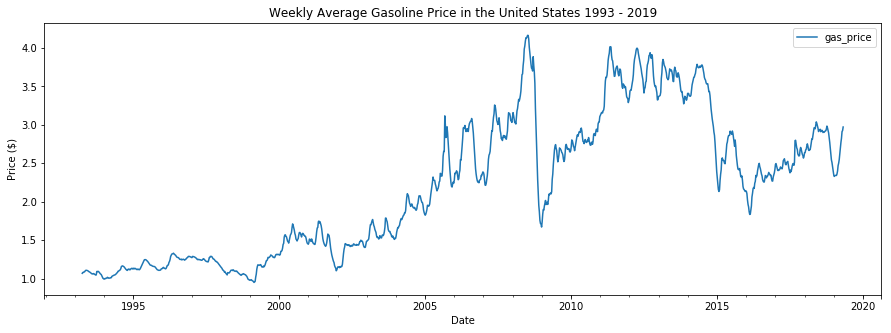

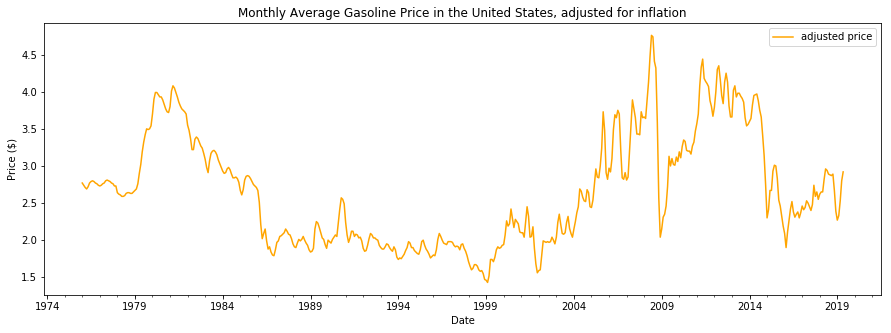

In [24]:
#Plotting
df_gas.plot(figsize = (15, 5))
plt.title('Weekly Average Gasoline Price in the United States 1993 - 2019')
plt.ylabel('Price ($)');
plt.xlabel('Date');

df_gas_adj.plot(figsize = (15, 5), color = 'orange')
plt.title('Monthly Average Gasoline Price in the United States, adjusted for inflation')
plt.ylabel('Price ($)');
plt.xlabel('Date');

We can draw some interesting observations from this plot:
* Slow gradual increase of prices
* Spike and dip at random intervals
* A large dip roughly around the time of the 2008 financial crisis, enforcing our hypothesis that gas prices are related to the state of the US economy. 
* There seems to be an annual spike of varying sizes

 We already know that the series is going to be a heteroscedastic and autocorrelated time series, but let's plot it to confirm.

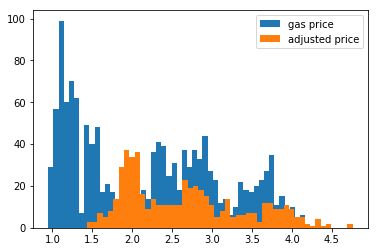

In [25]:
plt.hist(df_gas['gas_price'], 50, label = 'gas price');
plt.hist(df_gas_adj['adjusted price'], 50, label = 'adjusted price');
plt.legend(loc='best');

As exepcted, this is nowhere near a normal distribution.

Let's group by weeks & month to see if there are any seasonal patterns

In [26]:
month_avg = df_gas.groupby(df_gas.index.month).mean()
week_avg = df_gas.groupby(df_gas.index.week).mean()

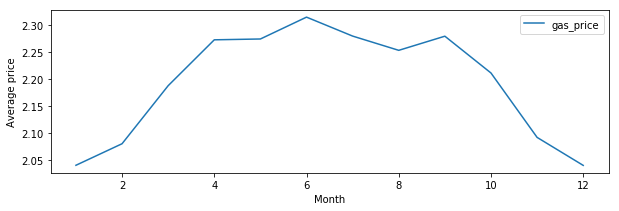

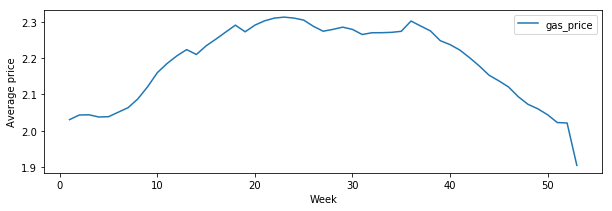

In [27]:
month_avg.plot(figsize = (10, 3))
plt.ylabel('Average price');
plt.xlabel('Month');

week_avg.plot(figsize = (10, 3))
plt.ylabel('Average price');
plt.xlabel('Week');

Comparing week and month averages, it seems that prices go up in the summer. To be more rigorous, we decided to plot a monthly histogram of prices:

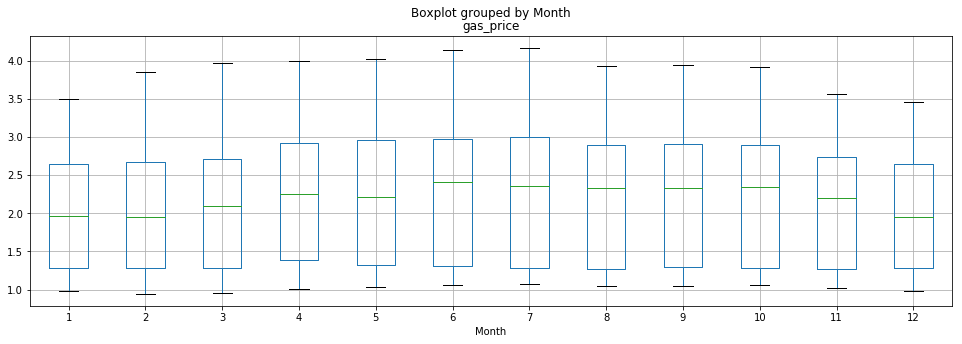

In [28]:
df_seasonal = df_gas.copy()
df_seasonal['Month'] = df_seasonal.index.month
df_seasonal.boxplot(by='Month', figsize = (16, 5));
plt.xlabel('Month');

We can see a graduating increasing in gas prices peaking in the summer, and decrease in prices bottoming in winter. Although there are slight variations in other month, the median price for June is higher than all other months. We explore this further by using a linear decomposition of our time series into a trend component and a seasonality component. The model (from statsmodels library) is as follows:
<h2><center>Y(t) = T(t) + S(t) + ε </center></h2>
Where Y is the dependent variable, T & S are trend & seasonality, and episilon is a random noise term.

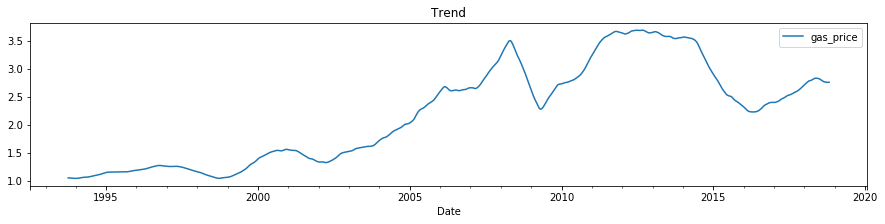

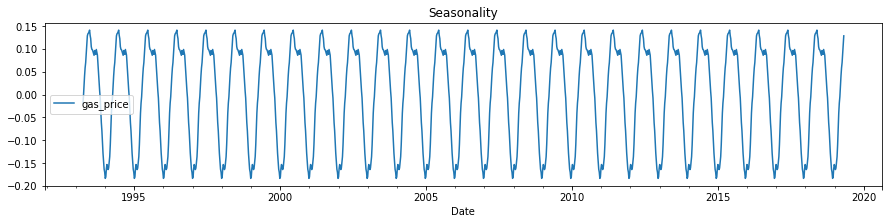

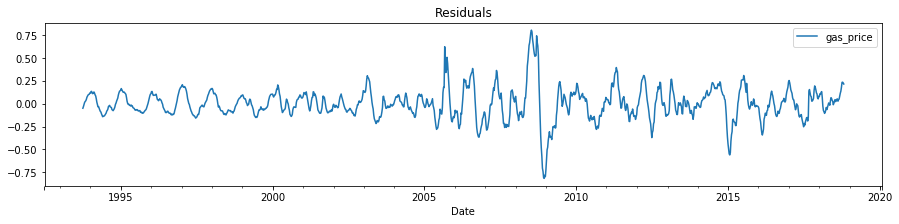

In [29]:
#fig, ax = plt.subplots(figsize=(16, 5))
result = seasonal_decompose(df_gas, model='additive')
result.trend.plot(figsize=(15, 3), title = 'Trend');
result.seasonal.plot(figsize=(15, 3), title = 'Seasonality');
result.resid.plot(figsize=(15, 3), title = 'Residuals');

We can see that stastmodels succefully decomposed our series into a trend component that models the gradual changes as well as a seasonality component with a frequency of one year, with the peak value at mid-year (June), which is what we predicted. We now assess how good is this decomposition. 
From the plot above, the residuals look pretty similar to white noise, we plot it to confirm:

C:\Users\JRVGo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\JRVGo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


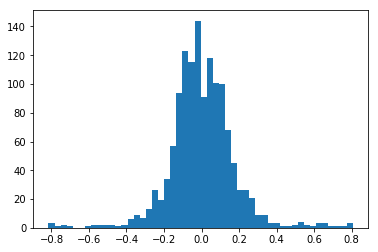

In [30]:
plt.hist(result.resid['gas_price'], 50);

We can see that the residuals are normally distributed, which implies that its probably close to white noise. Unfortunately, we cannot plot the autocorrelation function here because there are too many NaN values in the residual dataframe. We now reconstruct the time series from trend + seasonality and compare it with the original time series.

In [31]:
gas_reconstructed = pd.concat([result.seasonal.add(result.trend, fill_value=0), result.observed], axis=1)
gas_reconstructed.columns = ['reconstructed', 'observed']
rmse = np.sqrt(np.mean(result.resid['gas_price']**2))

Root-Mean Squared Error : 0.17223427610846742


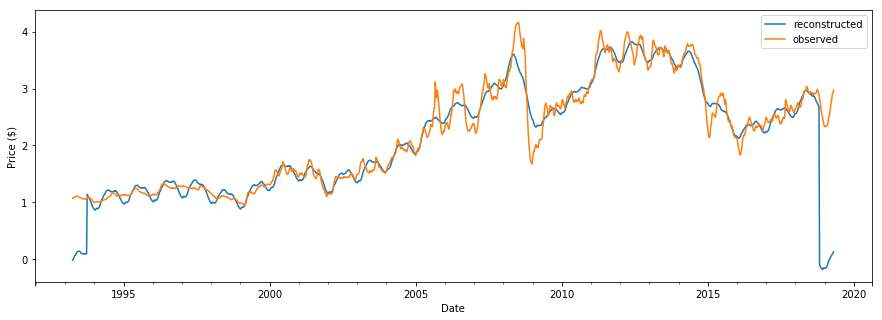

In [32]:
gas_reconstructed.plot(figsize = (15, 5))
plt.ylabel('Price ($)');
plt.xlabel('Date');
print('Root-Mean Squared Error : {}'. format(rmse))

This is a pretty good fit, although we can see that there are some components not explained by this decomposition.

### S&P 500

#### Plotting and resampling

Here, we resample the S&P500 data points to average by week in order to be able to actually plot them efficiently. Doing so also smooths out granularity irregularities at the daily level because the stock market closes on holidays and the weekends.

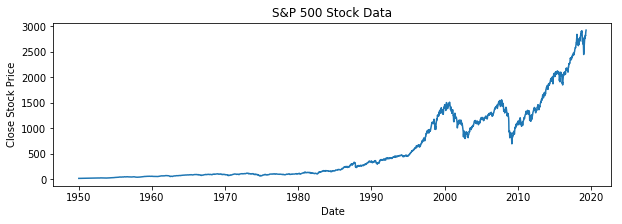

In [33]:
df_sp500_weekly = df_sp500['Close'].resample('W').mean()

plt.figure(figsize=(10, 3))
plt.plot(df_sp500_weekly.index, df_sp500_weekly)
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.title('S&P 500 Stock Data')
plt.show()

We only model Close here because of how closely Open follows the Close price. Later we will look at the Open price in more detail.

From this graph we can see that this stock has grown over time. This makes sense since the economy has grown since the 1950s and the value of the companies that this stock measures has grown since then as well. There a few major dips in the graph which should be represenative of economic crashes. We believe this to be true due the economic crash in 2008 and the represenative fall in the graph at the same time.

### NASDAQ

#### Plotting and resampling

Here, we resample the NASDAQ data points to average by week in order to be able to actually plot them efficiently. We see that the NASDAQ open stock prices have been increasing over time with corresponding local rises and dips in the market.

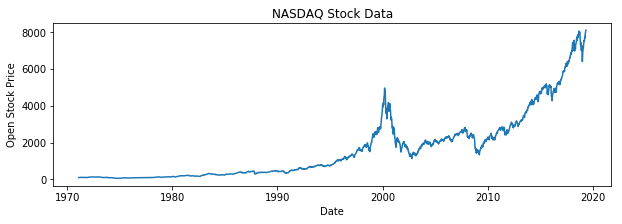

In [34]:
df_nasdaq_weekly = df_nasdaq['Open'].resample('W').mean()

plt.figure(figsize=(10, 3))
plt.plot(df_nasdaq_weekly.index, df_nasdaq_weekly)
plt.xlabel('Date')
plt.ylabel('Open Stock Price')
plt.title('NASDAQ Stock Data')
plt.show()

### Dow Jones Industrial Average

#### Plotting

Text(0.5, 1.0, 'DJIA Stock Data')

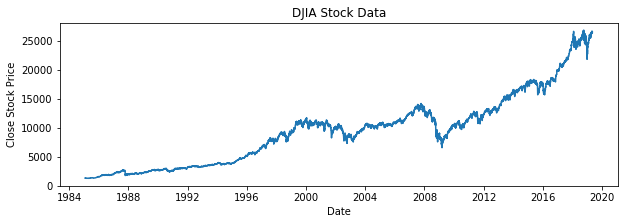

In [35]:
plt.figure(figsize=(10, 3))
plt.plot(df_dji['Close'])
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.title('DJIA Stock Data')

In [36]:
df_dji.describe()

,Close
count,8636.000000
mean,9500.461189
std,6096.591724
min,1242.050049
25%,3566.230042
50%,9870.679688
75%,12453.862549
max,26828.390625


#### Structure: 
DOW Jones Industrial Average Data came from a CSV. Each observation is in a seperate row. There is daily a data observation for approximately 70% of days in the 34 year span of 1985 to 2019. The data is 70% of days because it is only collected on the weekdays. The data is not spread across multiple tables.

#### Granularity: 
Each row (observation) represents the market value of the Dow Jones at the end of the weekday. The data is not summarized or aggregated, but instead used as a time-series model for its rate of change.

#### Scope: 
Data is comprehensive of the last 34 years, with the exception of weekend observations because the stock market is open 9:30am - 4pm Eastern, Monday - Friday.

#### Temporality: 
The date in the dataset represents the market value of the DOW at 4pm on weekdays (closing time). It is represented in YYYY-MM-DD. We plan to use this data as the x axis of our plot.

#### Faithfulness: 
The data is reasonable and to be expected. The data was measured by a computer and remains consistent across time. There are no obvious signs of falsification or any reason to disbelieve the data.

### Google Trends Data

#### Typical Values for relative interest in the term 'Gas Prices'

In [37]:
interest_df.describe()

,Gas prices
count,186.000000
mean,13.553763
std,11.292658
min,5.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,100.000000


We see that on average, the relative interest in 'Gas prices' is 13.5. It is important to note that this is unitless and represents a some normalized value in the range [0, 100], although Google states that a score of 0 means that there isn't enough data for a term. We see that the minimum value for this dataset is 5, so there was always enough data for this particular search term.

Raw search values are preferable but Google does not provide this information for privacy reasons.

#### Visualizing relative interest in term 'Gas Prices' over time

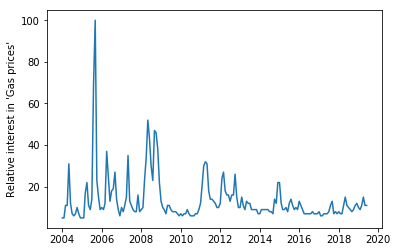

In [38]:
plt.plot(interest_df[kw])
plt.ylabel('Relative interest in \'{}\''.format(kw))
plt.show()

We see that the most queried period of time for 'Gas prices' was in 2005 with a second after the recession in 2008.

#### Using related queries as feedback to get more data

Google trends also provides keywords that it thinks are relevant to the provided keyword. This is useful because we can gather multiple keywords' worth of data and combine them to reduce the variance in any one search result.

In [39]:
def get_related_for_keyword(kw):
    kw_list = [kw]
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')
    related_df = pytrends.interest_over_time()
    return pytrends.related_queries()

In [40]:
# Modify these to grow the size of the tree and to choose a different starting keyword
start_kw = 'Gas prices'
num_iters = 5
k = 3 # Top-k related keywords to find per word


graph_dict = {}
q = deque()
q.append(start_kw)

for i in range(num_iters):
    # get the next keyword
    kw = q.popleft()
    print("Finding related terms to {}...".format(kw))
    
    # Get related keywords for given keyword
    related = get_related_for_keyword(kw)

    # Get the top k related keywords
    top_k = list(related[kw]['top'][:k]['query'].values)
    
    # Add to graph data dict
    if kw not in graph_dict:
        graph_dict[kw] = []
    graph_dict[kw] = top_k
    
    q.extend(top_k)
print("Done")

Finding related terms to Gas prices...
Finding related terms to gas near me prices...
Finding related terms to gas price...
Finding related terms to natural gas prices...
Finding related terms to gas station near me prices...
Done


In [41]:
dot = Digraph()
dot.node_attr.update(color='lightblue2', style='filled')
dot.edge_attr.update(len='1.6')

for kw in graph_dict:
    dot.node(kw, kw)
    for child in graph_dict[kw]:
        dot.node(child, child)
        dot.edge(kw, child, length='1')
dot

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

From this graph, we can use any of the suggested keywords in combination with the existing keyword. We didn't include this in the project as it is somewhat tangential but this can be included in a future iteration that focuses more explicitly on the relationship between google trends data and gas prices.

## ARIMA

We have adopted the ARIMA model since we are predicting a variable into the future using all the information we have on the past. Multiple linear regression will not work well for this approach for three reasons:
1. Our time series violates the assumption on homoscedacity, its mean and variance chances constantly across time.
2. It's also autocorrelated, which means that the residuals from a OLS fit would not be linear.
3. Multiple linear regression assumes no temporality which is a key component of forecasting. It also cannot predict into the future

$$ Y_t = a + \mu + \sum_{i = 1}^{p}b_iY_{t-i} + \sum_{j=1}^{q}d_j\varepsilon _{t-j} + \epsilon $$

It has three parameters:
* P: Number of AR regressors (A linear regression of Y with its past values).
* D: Order of differcing. This is to remove any linear trends.
* Q: Number of MA regressors (A linear regression of Y with its error values).

### Manual Parameter Selection

#### Order of Differencing (d)

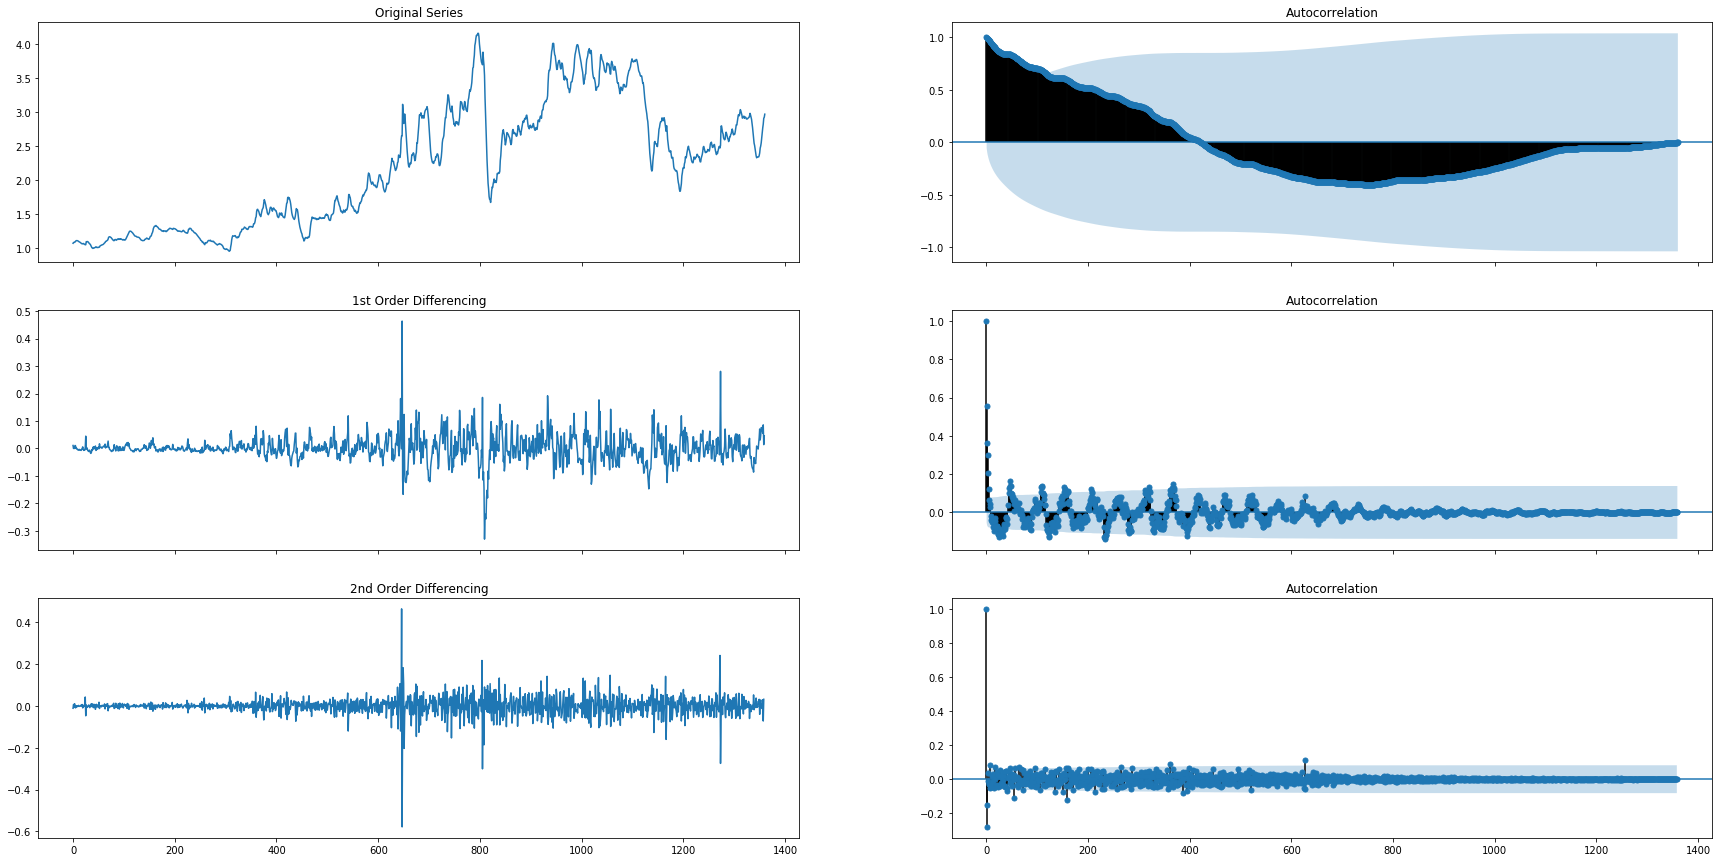

In [42]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(df_gas.values); axes[0, 0].set_title('Original Series')
plot_acf(df_gas.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df_gas.values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df_gas.values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df_gas.values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df_gas.values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [43]:
adf_dif0 = adfuller(df_gas['gas_price'])
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(df_gas['gas_price'], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(df_gas['gas_price'], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic: -2.056594 p-value: 0.262322
ADF Statistic: -10.797902 p-value: 0.000000
ADF Statistic: -12.242284 p-value: 0.000000


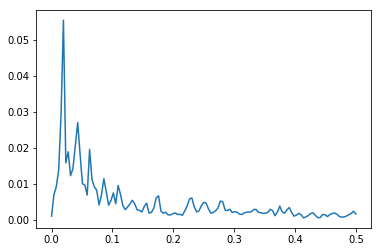

In [44]:
freqs, pw = sp.signal.welch(np.diff(df_gas['gas_price'].values))
plt.plot(freqs, pw)

We do an ad-fuller test to determine whether the series is stationary, based on above, 1st order differencing is more than enough.

#### Number of lags in the AR model (p)

We plot the PACF of the 1st-differenced prices to see how well lagged observations explain variations in the data

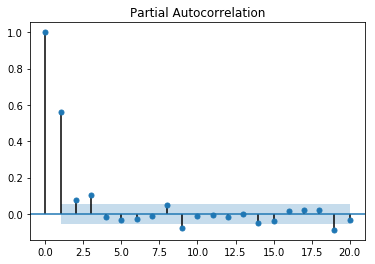

In [45]:
plot_pacf(np.diff(df_gas['gas_price'], axis = 0), lags = 20);

We can see from this plot that lags 1, 2, 3 , and 4 are significantly above the 95% confidence interval.

#### Number of lagged errors in the MA model (q)

We plot ACF to see how well lagged errors explain variations in the data

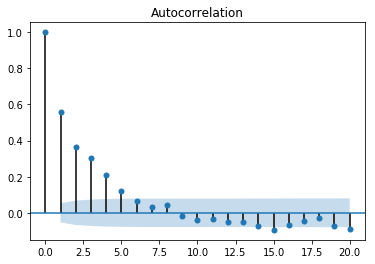

In [46]:
plot_acf(np.diff(df_gas['gas_price'], axis = 0), lags = 20);

### Fitting

In [47]:
order = np.array([2,1,1])
model = ARIMA(df_gas, order=order)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\JRVGo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
C:\Users\JRVGo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.gas_price   No. Observations:                 1360
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2470.672
Method:                       css-mle   S.D. of innovations              0.039
Date:                Wed, 12 Jun 2019   AIC                          -4931.344
Time:                        19:33:00   BIC                          -4905.268
Sample:                    04-12-1993   HQIC                         -4921.582
                         - 04-29-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0015      0.003      0.520      0.603      -0.004       0.007
ar.L1.D.gas_price     0.9368      0.139      6.760      0.000       0.665       1.208
ar.L2.D.gas_price    -0.

                 0
count  1360.000000
mean     -0.000005
std       0.039345
min      -0.353095
25%      -0.016618
50%      -0.001532
75%       0.014106
max       0.452933


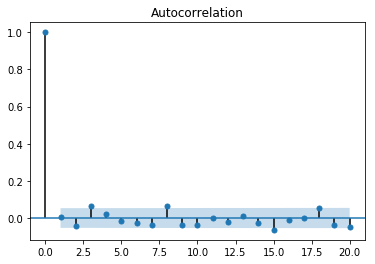

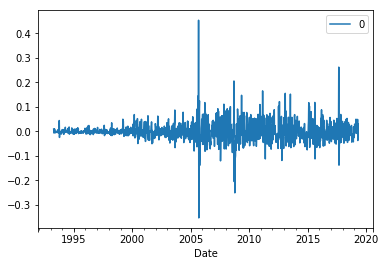

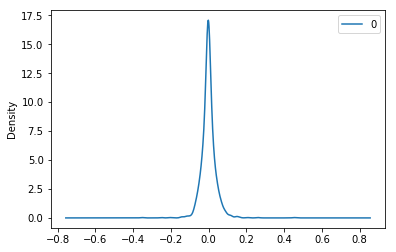

In [48]:
residuals = pd.DataFrame(model_fit.resid)
plot_acf(residuals, lags = 20);
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

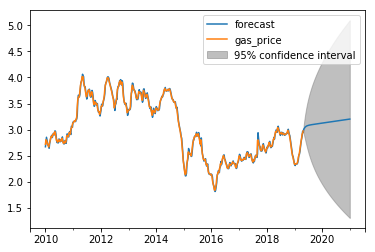

In [49]:
#plt.figure(figsize=(20,10))
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()

Seasonal ARIMA

- https://github.com/gmonaci/ARIMA/blob/master/time-series-analysis-ARIMA.ipynb
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [50]:
mod = sm.tsa.statespace.SARIMAX(df_gas,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

C:\Users\JRVGo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          gas_price   No. Observations:                 1361
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                2131.153
Date:                            Wed, 12 Jun 2019   AIC                          -4254.306
Time:                                    19:33:02   BIC                          -4233.519
Sample:                                04-05-1993   HQIC                         -4246.517
                                     - 04-29-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7168      0.022     33.233      0.000       0.675       0.759
ma.L1         -0.1890      0.024   

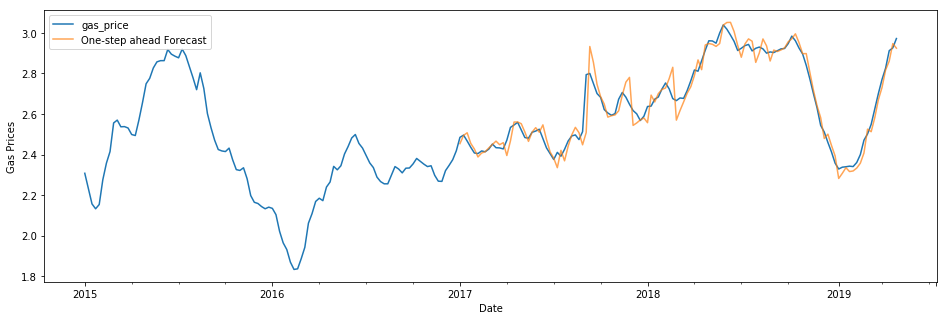

In [51]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-02'), dynamic=False)
ax = df_gas['2015':].plot(label='observed', figsize=(16,5))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Gas Prices')
plt.legend()
plt.show()

## Cross Correlation

In order to check the effectiveness of our model, we want to now how correlated our data is to gas. To do that we want a dataframe that holds all the data in a pairwise fasion (this means that the data points line up to one another), then we can check how correlated the data is.

We can now combine these dataframes into one to get how correlated they are. So we want to join the dataframes on their dates so that they line up to do a pairwise comparision. Then we want to drop any null values so that they are do not affect the analysis.

In [52]:
df_corr = pd.concat([df_gas, pd.DataFrame(df_dji['Close']), pd.DataFrame(df_sp500['Close']), \
                     pd.DataFrame(df_nasdaq['Close'])], axis=1, join_axes=[df_gas.index])
df_corr.columns = ["Gas", "Dow Jones", "S&P 500", "NASDAQ"]
df_corr.dropna(axis=0, inplace = True)   #Drop null values
df_corr.head()

,Gas,Dow Jones,S&P 500,NASDAQ
Date,,,,
1993-04-05,1.068,3379.189941,442.290009,670.710022
1993-04-12,1.079,3428.090088,448.369995,673.119995
1993-04-19,1.079,3466.989990,447.459991,663.030029
1993-04-26,1.086,3398.370117,433.540009,645.869995
1993-05-03,1.086,3446.459961,442.459991,666.710022


In [53]:
#Upsampling Google Trends Data
upsample = interest_df.resample('D')
interpolated = upsample.interpolate(method='linear')
interest_df = interpolated

In [54]:
df_corr_trends = pd.concat([df_gas, interest_df], axis=1, join_axes=[df_gas.index])
df_corr_trends = df_corr_trends.rename(columns={"gas_price": "Gas","Gas prices": "Google Trends"})
df_corr_trends.dropna(axis=0, inplace = True)   #Drop null values
df_corr_trends

,Gas,Google Trends,isPartial
Date,,,
2004-03-01,1.758,11.0,False
2004-11-01,2.076,7.0,False
2005-08-01,2.335,69.0,False
2006-05-01,2.966,25.0,False
2007-01-01,2.382,10.0,False
2007-10-01,2.838,8.0,False
2008-09-01,3.733,47.0,False
2008-12-01,1.870,22.0,False
2009-06-01,2.572,11.0,False


In [55]:
## Create 1D numpy arrays from dataframe columns
dji_array = df_corr['Dow Jones'].values
SP500_array = df_corr['S&P 500'].values
NASDAQ_array = df_corr['NASDAQ'].values
gas_array = df_corr['Gas'].values
gas_trends_array = df_corr_trends['Gas'].values
trends_array = df_corr_trends['Google Trends'].values
print(dji_array.shape, SP500_array.shape, NASDAQ_array.shape, gas_array.shape, gas_trends_array.shape, trends_array.shape)

(1235,) (1235,) (1235,) (1235,) (25,) (25,)


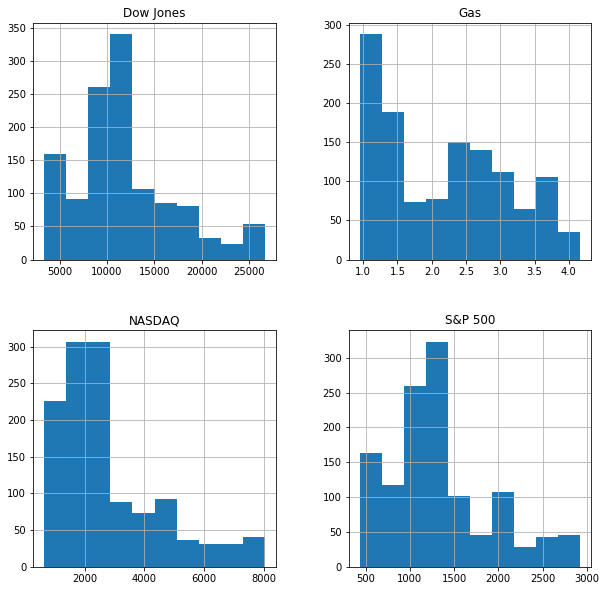

In [56]:
df_corr.hist(figsize = (10,10));

Since these original series are not normally distributed, we will use the spearman non-parametric correlation test to see if they are correlated. 

In [57]:
df_corr.corr(method='spearman')

,Gas,Dow Jones,S&P 500,NASDAQ
Gas,1.000000,0.749707,0.642804,0.662385
Dow Jones,0.749707,1.000000,0.974835,0.960259
S&P 500,0.642804,0.974835,1.000000,0.978440
NASDAQ,0.662385,0.960259,0.978440,1.000000


In [58]:
df_corr_trends.corr(method='spearman')

,Gas,Google Trends
Gas,1.000000,0.233181
Google Trends,0.233181,1.000000


All of our indices seem pretty interrcorrelated to each other, however, this doesn't give us the full picture, since each series can have effects on other series both into the past and into the future. To zoom in, we perform spearman correlation tests from -20 lag to +20 lag to see how correlation changes as we increase/decrease lags.

In [59]:
rhos_dji = []
pvals_dji = []
rhos_sp500 = []
pvals_sp500 = []
rhos_nasdaq = []
pvals_nasdaq = []
rhos_trends = []
pvals_trends = []

for lag in range(-20, 20):
    rho, pval = sp.stats.spearmanr(dji_array, pd.Series(gas_array).shift(lag).fillna(0))
    rhos_dji.append(rho)
    pvals_dji.append(pval)
    rho, pval = sp.stats.spearmanr(SP500_array, pd.Series(gas_array).shift(lag).fillna(0))
    rhos_sp500.append(rho)
    pvals_sp500.append(pval)
    rho, pval = sp.stats.spearmanr(NASDAQ_array, pd.Series(gas_array).shift(lag).fillna(0))
    rhos_nasdaq.append(rho)
    pvals_nasdaq.append(pval)
    rho, pval = sp.stats.spearmanr(trends_array, pd.Series(gas_trends_array).shift(lag).fillna(0))
    rhos_trends.append(rho)
    pvals_trends.append(pval)

## Non-Parametric Correlation

We plotted the cross-correlation between all stock data and google trends data to gas prices. The cross-correlation is roughly normally distributed.

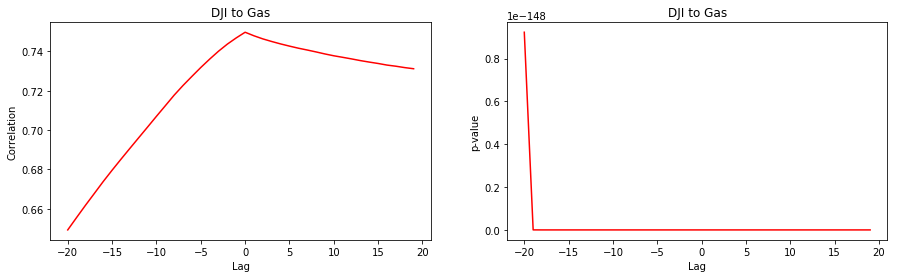

In [60]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_dji, color = 'r')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('DJI to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_dji, color = 'r')
plt.xlabel("Lag")
plt.ylabel("p-value")
plt.title('DJI to Gas')

plt.show()

In [61]:
print('lowest p-val: ', min(pvals_dji))
print('lag value: ', pvals_dji.index(min(pvals_dji)) - 20)
print('rho statistic: {}'. format(rhos_dji[pvals_dji.index(min(pvals_dji))]))

lowest p-val:  2.5891188260250825e-223
lag value:  0
rho statistic: 0.7497067871211748


Looks like the p-values for all the lags are signifcant, the most correlated & significant being lag 0, with a coefficient of .75. This means that the dow jones index is fairly correlated with gas prices. Even if they're not normally distributed, we can still plot them to see if DJI and gas prices have a monotonous relationship.

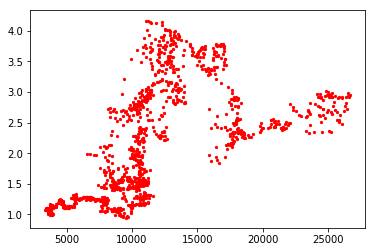

In [62]:
plt.scatter(dji_array, gas_array, s = 5, color = 'r');

Looks like they do have a rough monotonous relationship. Increases in DJI are coupled with increases in gas prices, although the relationship is not always linear. We can't say more than that because of the non-parametric nature of time series. We continue with the same approach for the rest of our indices.

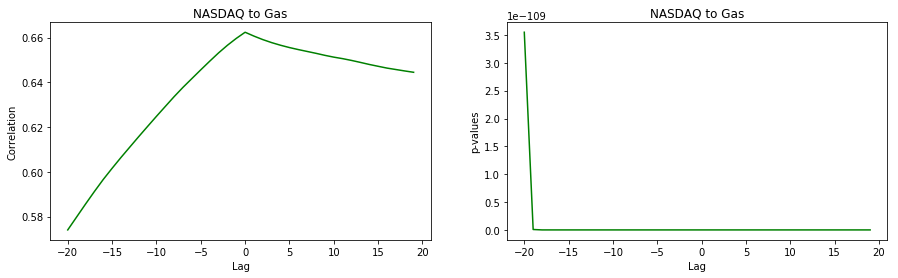

In [63]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_nasdaq, color = 'g')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('NASDAQ to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_nasdaq, color = 'g')
plt.xlabel("Lag")
plt.ylabel("p-values")
plt.title('NASDAQ to Gas')

plt.show()

In [64]:
print('lowest p-val: ', min(pvals_nasdaq))
print('lag value: ', pvals_nasdaq.index(min(pvals_nasdaq)) - 20)
print('rho statistic: {}'. format(rhos_nasdaq[pvals_nasdaq.index(min(pvals_nasdaq))]))

lowest p-val:  7.724219731446547e-157
lag value:  0
rho statistic: 0.6623849906096626


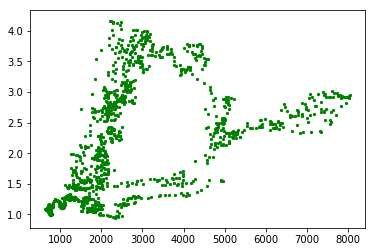

In [65]:
plt.scatter(NASDAQ_array, gas_array, s = 5, color = 'g');

We see that the lowest p-value, which is below 0.05, is at lag 0 with a r value of about 0.750

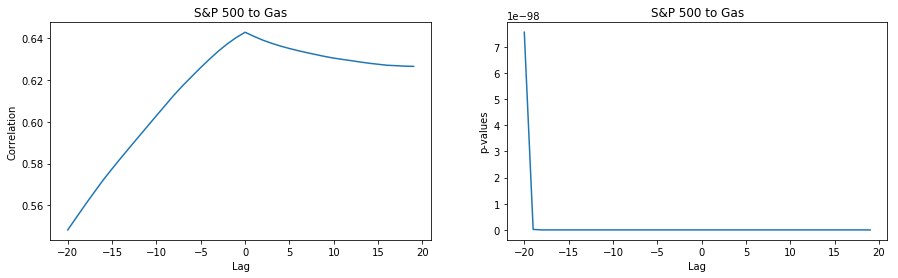

In [66]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_sp500)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('S&P 500 to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_sp500)
plt.xlabel("Lag")
plt.ylabel("p-values")
plt.title('S&P 500 to Gas')

plt.show()

In [67]:
print('lowest p-val: ', min(pvals_sp500))
print('lag value: ', pvals_sp500.index(min(pvals_sp500)) - 20)
print('rho statistic: {}'. format(rhos_sp500[pvals_sp500.index(min(pvals_sp500))]))

lowest p-val:  6.66048581929013e-145
lag value:  0
rho statistic: 0.6428036844556213


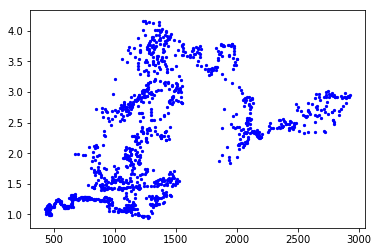

In [68]:
plt.scatter(SP500_array, gas_array, s = 5, color = 'b');

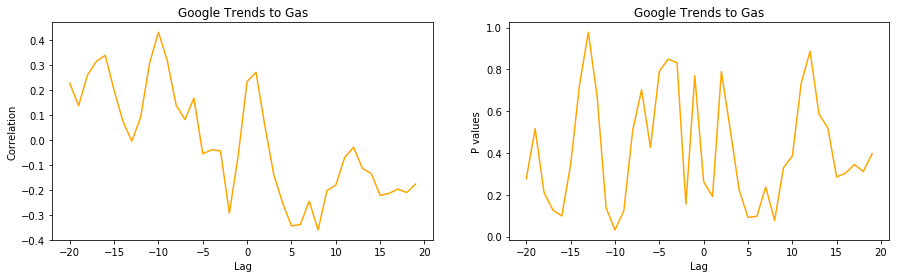

In [69]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_trends, color = 'orange')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('Google Trends to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_trends, color = 'orange')
plt.xlabel("Lag")
plt.ylabel("P values")
plt.title('Google Trends to Gas')
plt.show()

In [70]:
print('lowest p-val: ', min(pvals_trends))
print('lag value: ', pvals_trends.index(min(pvals_trends)) - 20)
print('rho statistic: {}'. format(rhos_trends[pvals_trends.index(min(pvals_trends))]))

lowest p-val:  0.031925458537727706
lag value:  -10
rho statistic: 0.42998406966346026


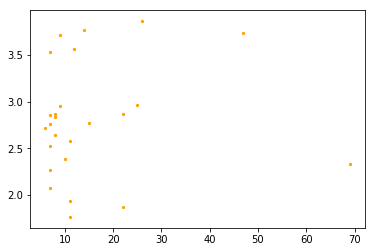

In [71]:
plt.scatter(trends_array, gas_trends_array, s = 5, color = 'orange');

We see a similar trend with the rest of the indices, with their peaks all at lag 0 and their peak correlation values from .6 to .8, except for google trends data which is at .4. It is also evident from the plot that google trends is less correlated than the stocks. What's also interesting is that we see correlation values drop off as we move away from lag 0, but it doesn't drop off very quickly. This could imply that if gas prices are influenced by stock prices and general performance of the economy, the effect is not just contemporaneous (past values influence both present and future values).

Now we know for sure that lag zero is the most signficant, we summarize our findings in a scatter matrix:

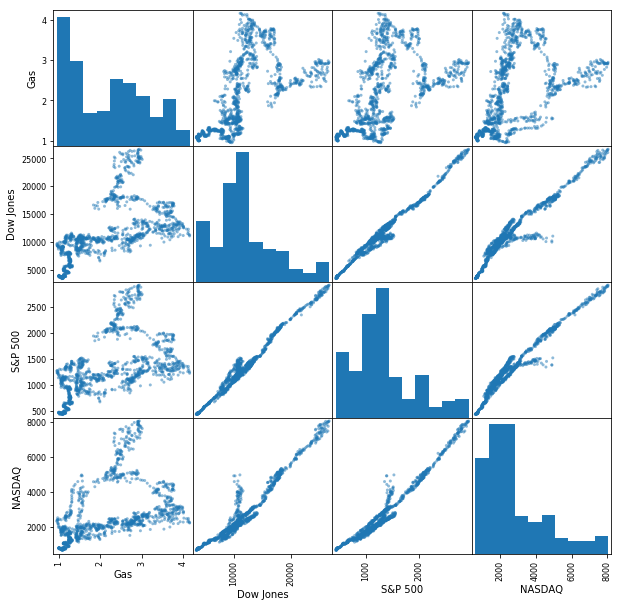

In [72]:
pd.plotting.scatter_matrix(df_corr, figsize = (10,10));

This gives us some more information in that stocks are very heavily correlated with each other.

# Differencing the Data

Now we will difference the data to get our time-series to be stationary. This allows us to make more conclusive statements about the correlation of our data. After differencing, we are essentially dealing with the derivatives of our data, which is how they change from one week to the next. 

In [73]:
## Difference the data to get a stationary time series
dji_array = pd.Series(np.diff(dji_array))
SP500_array = pd.Series(np.diff(SP500_array))
NASDAQ_array = pd.Series(np.diff(NASDAQ_array))
gas_array = pd.Series(np.diff(gas_array))
gas_trends_array = pd.Series(np.diff(gas_trends_array))
trends_array = pd.Series(np.diff(trends_array))

In [74]:
df_corr.head()

,Gas,Dow Jones,S&P 500,NASDAQ
Date,,,,
1993-04-05,1.068,3379.189941,442.290009,670.710022
1993-04-12,1.079,3428.090088,448.369995,673.119995
1993-04-19,1.079,3466.989990,447.459991,663.030029
1993-04-26,1.086,3398.370117,433.540009,645.869995
1993-05-03,1.086,3446.459961,442.459991,666.710022


In [75]:
df_corr['Gas'] = df_corr['Gas'].diff()
df_corr['Dow Jones'] = df_corr['Dow Jones'].diff()
df_corr['S&P 500'] = df_corr['S&P 500'].diff()
df_corr['NASDAQ'] = df_corr['NASDAQ'].diff()
df_corr.dropna(axis=0, inplace = True)

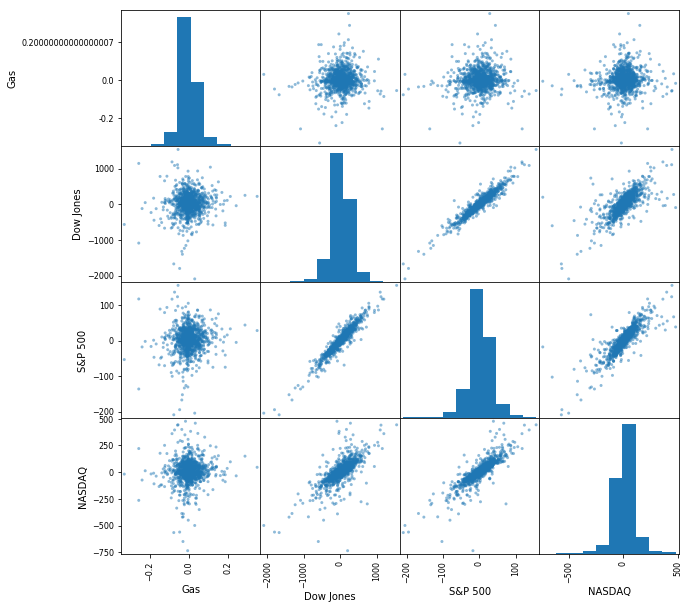

In [76]:
pd.plotting.scatter_matrix(df_corr, figsize = (10,10));

From this scatter matrix, we get a sense that our differenced data is normal and that there are signifcant correlations we can use to do a linear regression, so we preform a normal test on all of the data.

In [77]:
def isnormal(arr, alpha = .05):
    stat, pval = sp.stats.normaltest(arr)
    if pval < alpha:
        return False
    if pval > alpha:
        return True
    
df_corr.apply(isnormal)

Gas          False
Dow Jones    False
S&P 500      False
NASDAQ       False
dtype: bool

After all the normal tests, all the p-values were below 0.05 which tells us the data is actually not normal. Looking at the histogram again, this might be a kurtosis issue, since stock have drastic changes, thus giving outliers. This means we still cannot perform a pearson test. However, we can still use a least squares regression to model changes in gas prices from chagnes in stocks. We drop the google trends data because of sample size issues

In [78]:
X = df_corr[['Dow Jones', 'S&P 500', 'NASDAQ']]
y = df_corr['Gas']

olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                    Gas   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.414
Date:                Wed, 12 Jun 2019   Prob (F-statistic):             0.0169
Time:                        19:33:09   Log-Likelihood:                 1921.1
No. Observations:                1234   AIC:                            -3836.
Df Residuals:                    1231   BIC:                            -3821.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Dow Jones  -2.329e-05   1.92e-05     -1.216      0.2

From the results, we can see that none of the stocks changes were very predictive of gas changes, even though they were fairly correlated. This gives an important insight: just because they are correlated does not mean they will be able to accurately predict gas prices.

# Ethics & Privacy

We had to consider whether our sources of data are of good enough quality to answer our question. The data that we are using is widely used government data, so we can be fairly confident that it is of good quality. A bigger concern may be whether the scope of data we are using is wide enough. We looked at DJIA, S&P 500, and NASDAQ but these may not be the most representative or unbiased sources of data to answer the question at hand. The data could potentially be biased due to the DJIA not accurately reflecting the purchasing power of certain groups, since it is an index of the 30 biggest publicly owned companies. For the S&P 500, when a company performs poorly, it is removed from the index. But its past performance still influences the index and that is not removed. This is known as survivorship bias and it might have influenced our results slightly. Finally, for the NASDAQ dataset, there is also a chance of [survivorship bias](https://dqydj.com/survivorship-bias/). 

Since we are using gross averages and public data about stocks and gas prices, we don’t have to worry about maintaining privacy and informed consent in our project. 

Finally, we had to consider the implications of our results. Assuming we are able to perfectly predict gas prices, it may affect the actual gas prices, thus potentially changing our results. We would have to continually use current data and rerun our analyses to ensure that any observed trend is consistent.

Overall, using widely cited and used public data for our project ensures that the data is reliable and of good quality. We may have some issues with the scope of our data and the confounding variables and correlations that may result, but we can continue to add good data to increase the confidence in our results as our project progresses.

# Conclusion & Discussion

Our project helped us reach some very interesting conclusions about economic indicators and gas prices. Our hypothesis stated that we expected to build an accurate model to predict historical gas prices. First, we were able to confirm that gas prices and the economy are related to one another, as evidenced by the plots dipping around the time of the 2008 financial crisis. Next, we discovered a slight increase in gas prices during the summer. While we did not focus on this during our project, it is very possible this slight increase in gas prices is due to an increase of traveling and vacations taken. Next, we were also able to build and fit an ARIMA model relatively well to predict gas prices. The only issue we came across with our ARIMA model was some small mean error.  Finally,  using the spearman nonparametric test, we found out that Dow Jones, NASDAQ, S&P 500, and Gas Prices were relatively intercorrelated. Through nonparametric correlation, we found significant p-values between .6-.8 for all the datasets and Gas prices, showing that there is a strong correlation between economic indicators and gas prices. There was a less strong correlation between google trends data and gas prices.  

While we came to these conclusions, we also reached an overall conclusion about our hypothesis. Ultimately, by going through our regression results, we discovered that economic indicators are not a strong predictor of gas changes. While all the indicator datasets were strongly correlated with gas changes, they did not prove to be strong predictors of gas changes. One reason for this could be the bias talked about in our ethics and privacy section. While they may have been seemingly insignificant, the survivorship bias could have had a strong impact on the datasets, while there is no such thing as survivorship bias for gas prices. Another reason could be that while stocks are primarily influenced by economic factors like inflation and interest rates, gas prices are often impacted by foreign affairs, political events, and other influences we did not take into account. 

In a future project, we could improve the predictive ability by expanding past just stock datasets and looking at other popular economic indicators. We could also incorporate foreign economic influences, since the economic state of countries supplying our oil impacts gas prices. 